In [26]:
import matplotlib.ticker as mtick
import locale

# Ustawienie lokalizacji na polską (dla przecinka dziesiętnego)
try:
    locale.setlocale(locale.LC_NUMERIC, 'pl_PL.UTF-8')
except locale.Error:
    locale.setlocale(locale.LC_NUMERIC, '')  # Fallback na systemową lokalizację



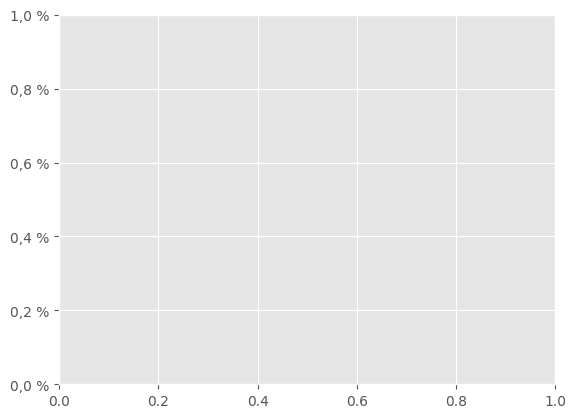

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Formatowanie osi Y na procenty z przecinkiem
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x:.1f}".replace('.', ',') + ' %')
)

In [28]:


model = 'llama3'
# Ścieżka do folderu z plikami
folder_path = f"extracted_new/results/cot_random_samples_cohere_temp0.3/{model}"


# Mapowanie datasetów na zbiory etykiet
label_sets = {
    "20_newsgroups": {
        "rec.sport.hockey", "soc.religion.christian", "rec.sport.baseball",
        "rec.motorcycles", "sci.crypt", "rec.autos", "sci.med", "sci.space",
        "comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware", "sci.electronics",
        "comp.windows.x", "comp.graphics", "misc.forsale", "comp.sys.mac.hardware",
        "talk.politics.mideast", "talk.politics.guns", "alt.atheism",
        "talk.politics.misc", "talk.religion.misc"
    },
    "ag_news": {"World", "Sports", "Business", "Sci/Tech"},
    "go_emotions": {
        "disapproval", "curiosity", "fear", "disgust", "annoyance", "remorse",
        "neutral", "excitement", "realization", "joy", "embarrassment", "sadness",
        "anger", "desire", "approval", "love", "disappointment", "amusement",
        "surprise", "optimism", "gratitude", "admiration", "confusion", "caring"
    },
    "social_media": {"not depression", "moderate", "severe"},
    "sst5": {"1", "2", "3", "4", "5"},
    "yahoo": {
        "Society & Culture", "Science & Mathematics", "Health", "Education & Reference",
        "Computers & Internet", "Sports", "Business & Finance", "Entertainment & Music",
        "Family & Relationships", "Politics & Government"
    }
}

custom_labels = [
    "20 Newsgroups", 
    "AG News", 
    "GoEmotions", 
    "SST-5", 
    "Social Media", 
    "Yahoo"
]




# Zbieranie wyników
import numpy as np
results = {}


for dataset, valid_labels in label_sets.items():
    error_percentages = []
    files = [f for f in os.listdir(folder_path) if f.startswith(dataset) and f.endswith(".csv")]

    for file in files:
        df = pd.read_csv(os.path.join(folder_path, file))
        if "extracted_label" not in df.columns:
            continue
        extracted = df["extracted_label"].astype(str).str.lower()
        invalid = ~extracted.isin({label.lower() for label in valid_labels})
        error_percentage = (invalid.sum() / len(df)) * 100
        error_percentages.append(error_percentage)

    results[dataset] = {
        "mean": np.mean(error_percentages),
        "std": np.std(error_percentages)
    }



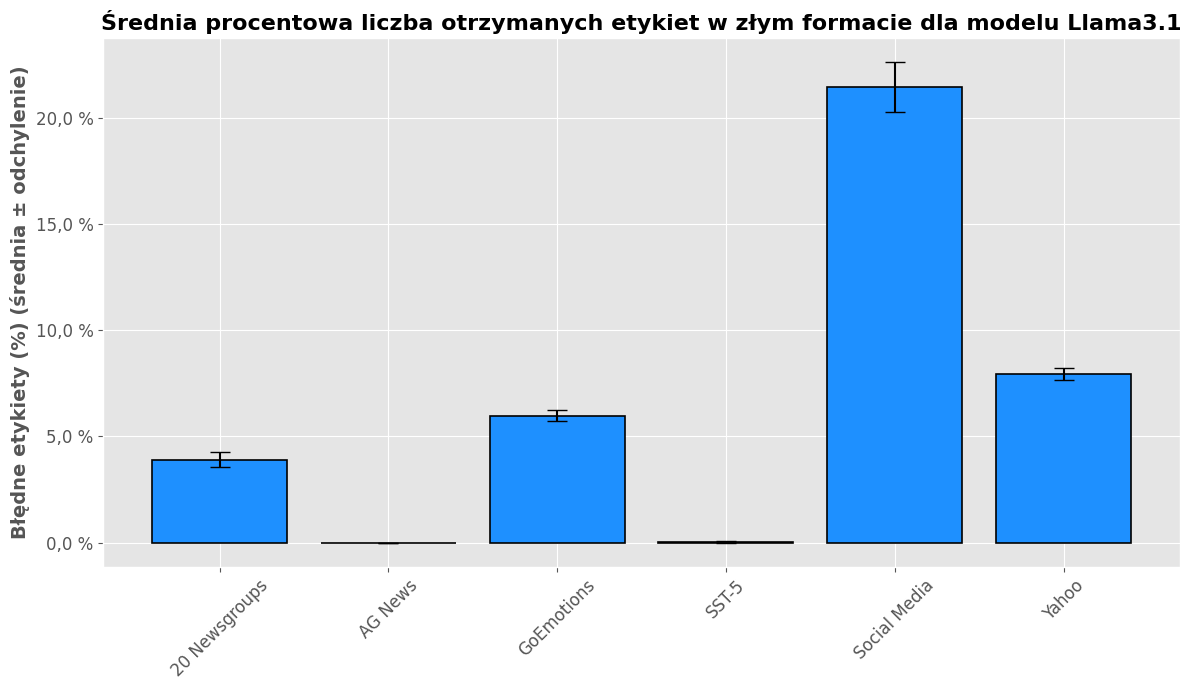

In [29]:
# Przygotowanie do wykresu
datasets = list(results.keys())
means = [results[ds]["mean"] for ds in datasets]
stds = [results[ds]["std"] for ds in datasets]

# Stylizacja wykresu
plt.style.use('ggplot')
plt.figure(figsize=(12, 7))
bars = plt.bar(datasets, means, yerr=stds, capsize=7, color='dodgerblue', edgecolor='black', linewidth=1.2)

plt.ylabel('Błędne etykiety (%) (średnia ± odchylenie)', fontsize=14, weight='bold')
plt.title('Średnia procentowa liczba otrzymanych etykiet w złym formacie dla modelu Llama3.1', fontsize=16, weight='bold')
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=45, fontsize=12)

plt.yticks(fontsize=12)

import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x:.1f}".replace('.', ',') + ' %')
)

plt.tight_layout()
# plt.show()
plt.savefig(f'figure/invalid_labels_plot_{model}.png', format='png')


In [30]:
import pandas as pd
import os
import numpy as np

folder_path = "extracted_new/results/cot_random_samples_cohere_temp0.3/llama3"
datasets = ["20_newsgroups", "ag_news", "go_emotions", "social_media", "sst5", "yahoo"]
results = {}

for dataset in datasets:
    files = sorted([f for f in os.listdir(folder_path) if f.startswith(dataset) and f.endswith(".csv")])
    dfs = []

    for i, file in enumerate(files):
        df = pd.read_csv(os.path.join(folder_path, file))
        if 'text' in df.columns and 'extraction_complete' in df.columns:
            temp_df = df[['text', 'extraction_complete']].drop_duplicates(subset='text', keep='first')
            
            def safe_convert(x):
                try:
                    return str(int(float(x)))
                except (ValueError, TypeError):
                    return 'NA'

            if dataset == "sst5":
                temp_df['extraction_complete'] = temp_df['extraction_complete'].apply(safe_convert)

            temp_df.rename(columns={'extraction_complete': f'extraction_complete_{i}'}, inplace=True)
            dfs.append(temp_df)

    if len(dfs) < 2:
        print(f"⚠️ Pominięto {dataset} – znaleziono tylko {len(dfs)} plik(ów), za mało do analizy.")
        continue

    # Merge stopniowy po 'text'
    merged = dfs[0]
    for i in range(1, len(dfs)):
        merged = pd.merge(merged, dfs[i], on='text', how='inner')

    extraction_cols = [col for col in merged.columns if col.startswith('extraction_complete')]

    # Liczba unikalnych wartości dla każdego wiersza
    merged['unique_extraction_values'] = merged[extraction_cols].nunique(axis=1)

    total_texts = len(merged)
    unstable_gt1 = (merged['unique_extraction_values'] > 1).sum()
    unstable_gt2 = (merged['unique_extraction_values'] > 2).sum()

    results[dataset] = {
        'gt1_percent': (unstable_gt1 / total_texts) * 100,
        'gt2_percent': (unstable_gt2 / total_texts) * 100,
        'gt1_count': unstable_gt1,
        'gt2_count': unstable_gt2,
        'total': total_texts,
        'files_used': len(dfs)
    }

# Podgląd wyników
for ds, res in results.items():
    print(f"{ds}: {res}")


20_newsgroups: {'gt1_percent': 21.854636591478695, 'gt2_percent': 2.807017543859649, 'gt1_count': 436, 'gt2_count': 56, 'total': 1995, 'files_used': 4}
ag_news: {'gt1_percent': 6.2, 'gt2_percent': 0.0, 'gt1_count': 62, 'gt2_count': 0, 'total': 1000, 'files_used': 5}
go_emotions: {'gt1_percent': 60.06256517205423, 'gt2_percent': 23.2533889468196, 'gt1_count': 1152, 'gt2_count': 446, 'total': 1918, 'files_used': 5}
social_media: {'gt1_percent': 34.35897435897436, 'gt2_percent': 1.6666666666666667, 'gt1_count': 268, 'gt2_count': 13, 'total': 780, 'files_used': 5}
sst5: {'gt1_percent': 38.2, 'gt2_percent': 0.8999999999999999, 'gt1_count': 382, 'gt2_count': 9, 'total': 1000, 'files_used': 5}
yahoo: {'gt1_percent': 16.3, 'gt2_percent': 1.6, 'gt1_count': 163, 'gt2_count': 16, 'total': 1000, 'files_used': 5}


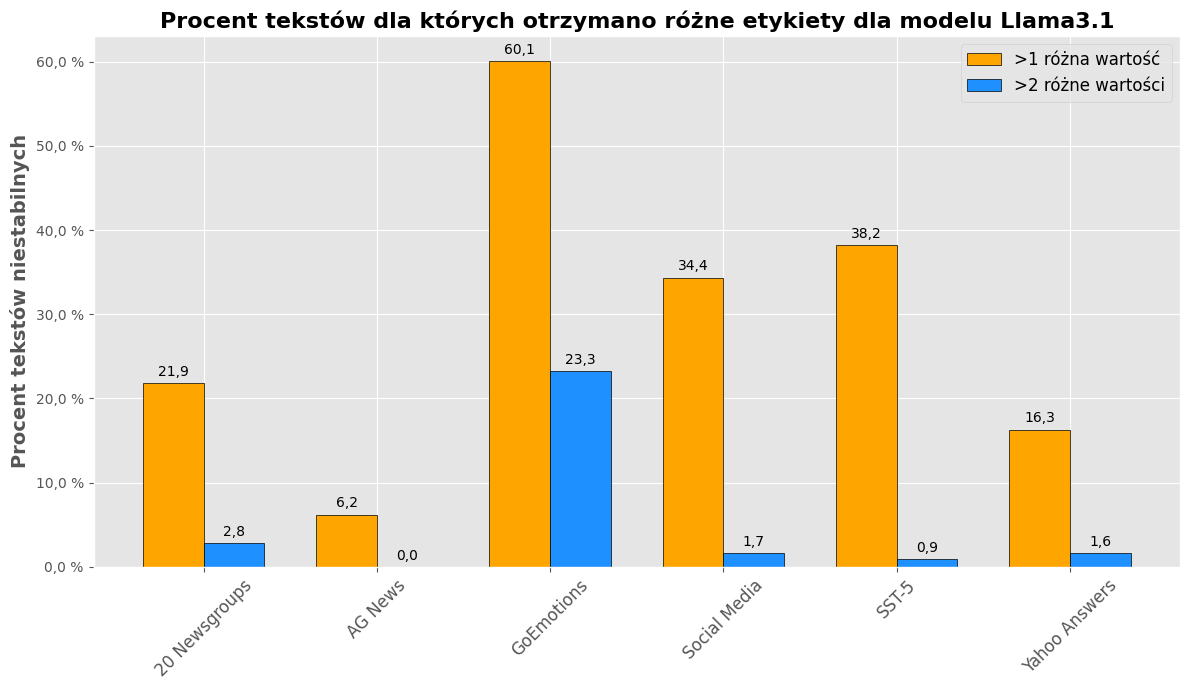

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

dataset_labels = ["20 Newsgroups", "AG News", "GoEmotions", "Social Media", "SST-5", "Yahoo Answers"]

# Pobierz dane
gt1_percents = [results[ds]['gt1_percent'] for ds in datasets]
gt2_percents = [results[ds]['gt2_percent'] for ds in datasets]

# Styl
plt.style.use('ggplot')
x = np.arange(len(dataset_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, gt1_percents, width, label='>1 różna wartość', color='orange', edgecolor='black')
bars2 = ax.bar(x + width/2, gt2_percents, width, label='>2 różne wartości', color='dodgerblue', edgecolor='black')

ax.set_ylabel('Procent tekstów niestabilnych', fontsize=14, weight='bold')
ax.set_title('Procent tekstów dla których otrzymano różne etykiety dla modelu Llama3.1', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dataset_labels, rotation=45, fontsize=12)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.1f}".replace('.', ',') + ' %'))
ax.legend(fontsize=12)

# Dodaj wartości nad słupkami
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}'.replace('.', ','),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
# plt.show()
plt.savefig(f'figure/unstable_labels_plot_{model}.png', format='png')
